In [2]:
import random
import string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy.matlib as npmatlib
%matplotlib inline

import dataloader
import util
import esmda_full

#load data
dataset = dataloader.DataLoader(verbose=True)
x_train, x_test, y_train, y_test, y_reg_train, y_reg_test = dataset.load_data()

#vectorize the images
x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1]*x_train.shape[2]])
x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1]*x_test.shape[2]])

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

Loaded training data x (60000, 28, 28, 1) and y (60000, 128) and y_labels (60000,)
Loaded testing data x (10000, 28, 28, 1) and y (10000, 128) and y_labels (10000,)


In [3]:
#da workflow 
ref_case = 3
N_a = 4
alpha = [80, 30, 4, 1.5]
sz = 28
num_samples = 1000

#data: in practice, remove/hide the ref_case from the ensemble
d_obs = y_reg_test[ref_case:ref_case+1, :].T

#call esmda method
G = np.load('G.npy')
esmda_method = esmda_full.ESMDA(ref_case, d_obs, G, dataset.maxs, x_test[0:num_samples], y_reg_test[0:num_samples])
Ensemble, Ensemble_d = esmda_method.assimilate(N_a, alpha)

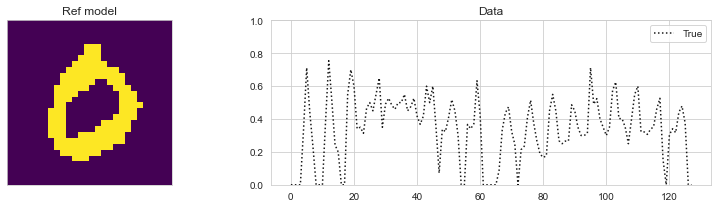

In [4]:
m_ref = x_test[ref_case:ref_case+1, :]

#model (i.e. reference case)
f = plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.imshow(np.reshape(x_test[ref_case], [sz, sz]), cmap="viridis", vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.title("Ref model")

#data 
ax = f.add_subplot(1, 2, 2)
plt.plot(y_reg_test[ref_case, :], ls=':', c='k', label='True', alpha=0.9)
plt.ylim([0, 1])
plt.title("Data")
plt.legend()

plt.tight_layout()

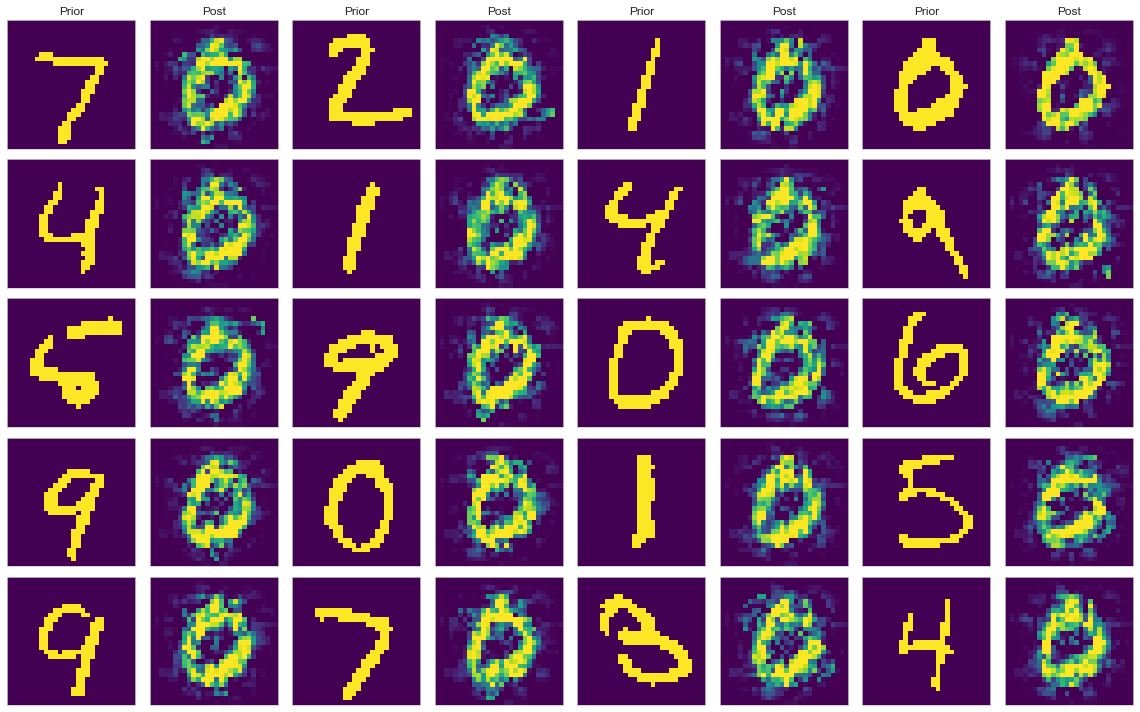

In [5]:
posteriors = Ensemble[1].T
    
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
    
f = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.reshape(x_test[i], [sz, sz]), cmap="viridis", vmin=0, vmax=1) 
    if i < 4:
        plt.title("Prior")
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.reshape(posteriors[i], [sz, sz]), cmap="viridis", vmin=0, vmax=1)
    if i < 4:
        plt.title("Post")
    
plt.tight_layout()
plt.show()

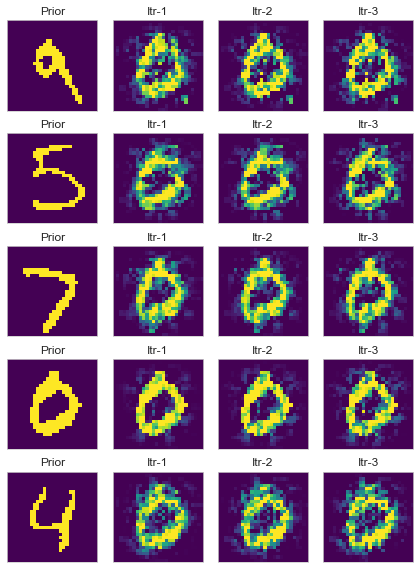

In [6]:
#display figures with iterations

img_itr1 = Ensemble[1].T
img_itr2 = Ensemble[2].T
img_itr3 = Ensemble[3].T

f = plt.figure(figsize=(6, 8))
for count, i in enumerate([7, 15, 17, 3, 4]):

    plt.subplot(5, 4, (4*(count))+1)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.reshape(x_test[i], [sz, sz]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Prior")
    
    plt.subplot(5, 4, (4*(count))+2)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.reshape(img_itr1[i], [sz, sz]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Itr-1")
    
    plt.subplot(5, 4, (4*(count))+3)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.reshape(img_itr2[i], [sz, sz]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Itr-2")
    
    plt.subplot(5, 4, (4*(count))+4)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.reshape(img_itr3[i], [sz, sz]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Itr-3")
    
plt.tight_layout()

In [7]:
#mean and variance of prior and posterior

def plotmvar(data1, data2, name=[]):
    f = plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(data1, [sz, sz]), cmap="viridis", vmin=0, vmax=1, aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title(name+"_$\mu$")

    plt.subplot(1, 2, 2)
    plt.imshow(np.reshape(data2, [sz, sz]), cmap="viridis", vmin=0, vmax=0.25)
    plt.xticks([]), plt.yticks([])
    plt.title(name+"_$\sigma$")
    plt.tight_layout()

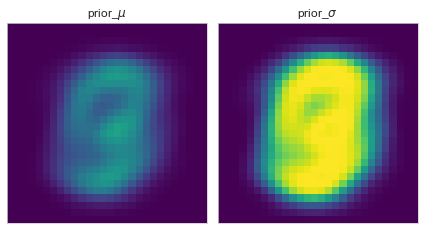

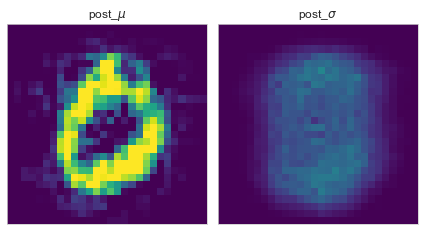

In [8]:
plotmvar(np.mean(x_test, axis=0), np.var(x_test, axis=0), name="prior")
plotmvar(np.mean(posteriors, axis=0), np.var(posteriors, axis=0), name="post")

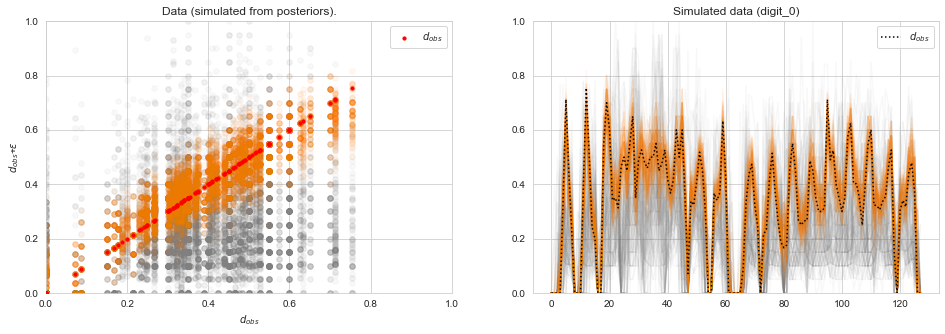

In [9]:
D_posteriors = esmda_method.simulator(posteriors)

#view posteriors simulated data
f = plt.figure(figsize=(16, 5))
ax = f.add_subplot(1, 2, 1)
plt.scatter(y_reg_test[ref_case,:].flatten(), y_reg_test[ref_case,:].flatten(), s=10, color='red', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.scatter(y_reg_test[ref_case,:].flatten(), y_reg_test[i,:].flatten(), s=30, color='gray', alpha=0.05)
for i in range(100):
    plt.scatter(y_reg_test[ref_case,:].flatten(), D_posteriors[i,:].flatten(), s=30, color=cs[y_test[ref_case]], alpha=0.05)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("$d_{obs}$")
plt.ylabel("$d_{obs}$"+"+$\epsilon$")
plt.legend()
plt.title('Data (simulated from posteriors).')

ax = f.add_subplot(1, 2, 2)
timesteps = np.linspace(0, 127, 128)
plt.plot(timesteps, y_reg_test[ref_case,:], ls=':', c='k', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.plot(timesteps, y_reg_test[i,:], color='gray', alpha=0.05)
for i in range(100):
    plt.plot(timesteps, D_posteriors[i,:], color=cs[y_test[ref_case]], alpha=0.05)
plt.ylim([0, 1])
plt.title('Simulated data (digit_'+str(y_test[ref_case])+')')
plt.legend()